In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [3]:
df

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No
...,...,...,...,...,...,...,...,...,...,...
9995,9996,1524,1475.988992,2023-01-07 22:35:00,Clothing,Los Angeles,95.068658,414.231539,desktop,Yes
9996,9997,4879,764.834233,2023-01-07 22:36:00,Clothing,Los Angeles,902.506946,1090.687430,mobile,No
9997,9998,2624,882.096776,2023-01-07 22:37:00,Travel,New York,531.237353,186.667431,mobile,No
9998,9999,4907,1.000000,2023-01-07 22:38:00,Dining,Chicago,0.000000,116.343224,desktop,No


In [ ]:
# Exploratory Date Analysis

In [4]:
# Convert date columns to datetime format
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

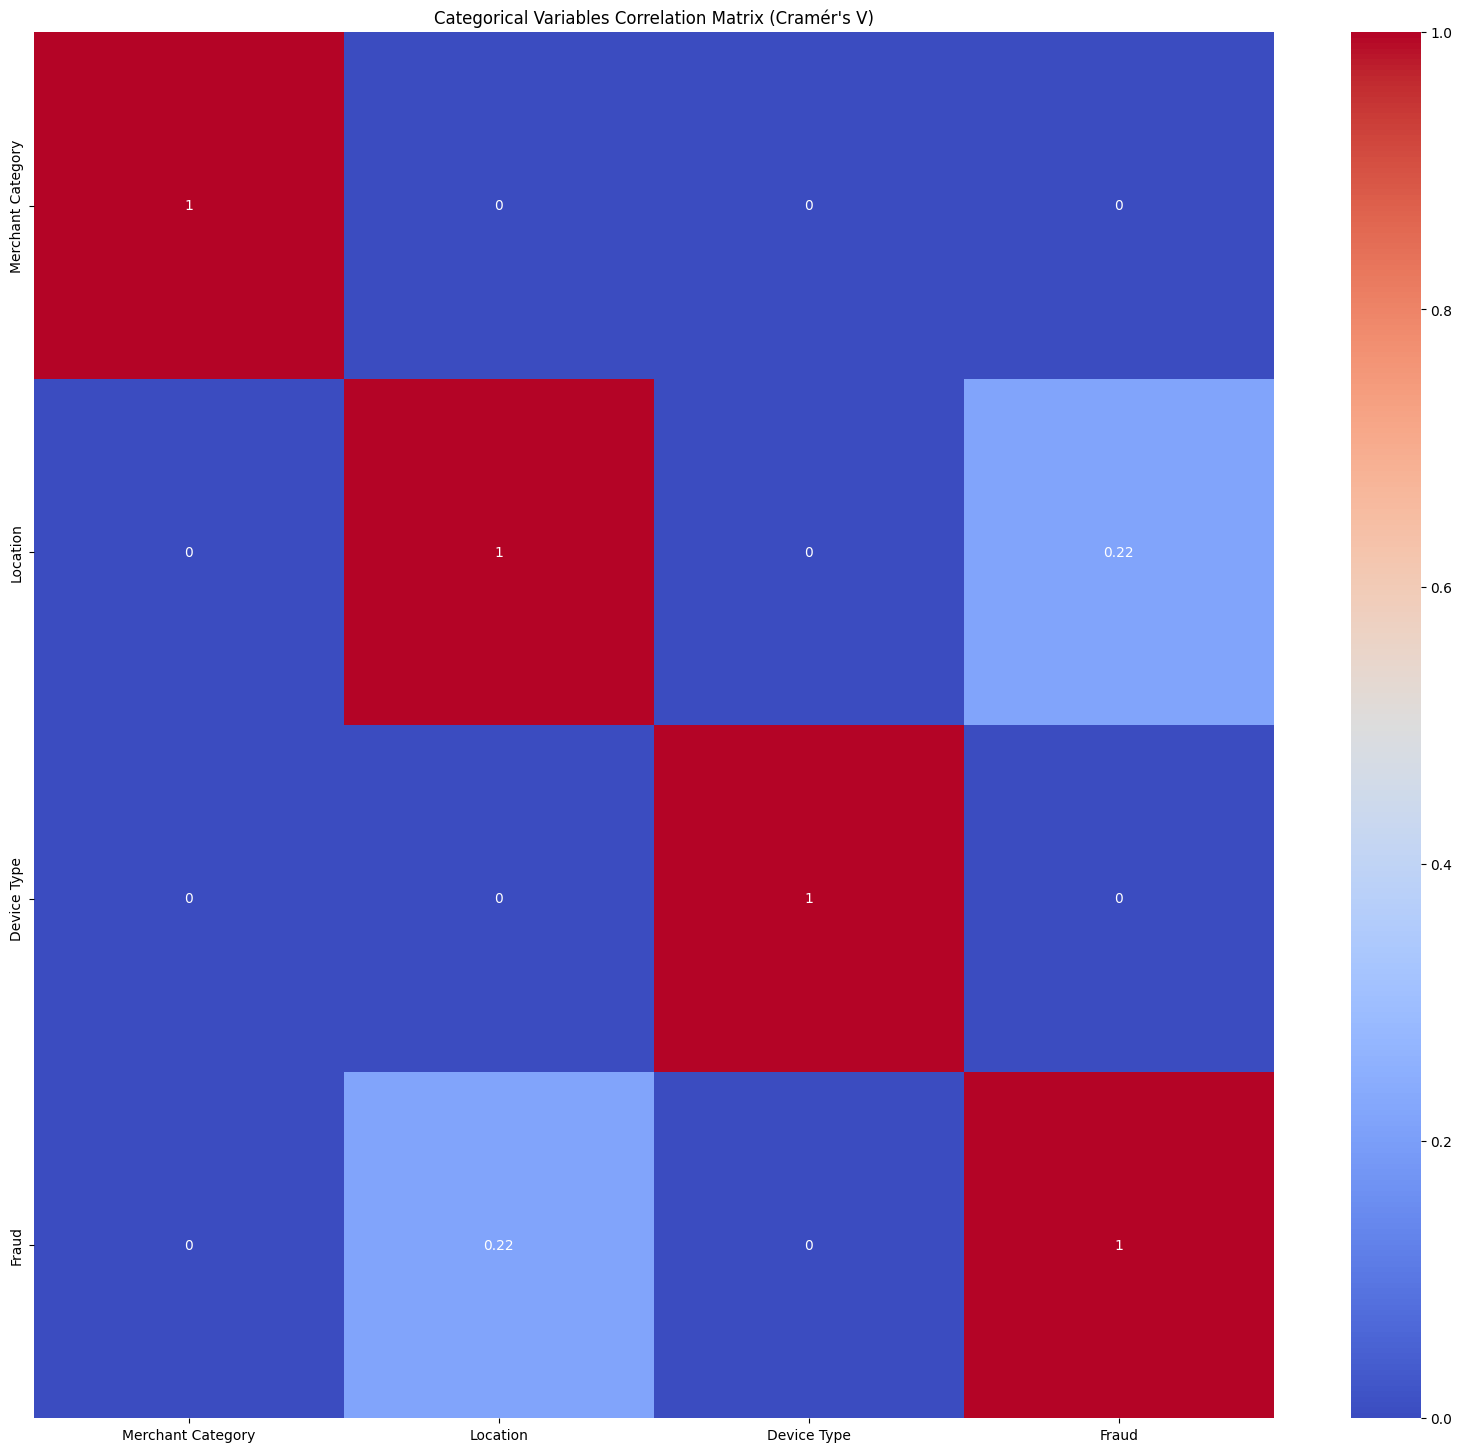

In [6]:
# show corelation between catigorical variables
def cramers_v(confusion_matrix):
    """Calculate Cramér's V for the given confusion matrix."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()  # Get total number of observations
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1) if n > 1 else 0)
    rcorr = r - ((r-1)**2)/(n-1) if n > 1 else r
    kcorr = k - ((k-1)**2)/(n-1) if n > 1 else k
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
# Select the categorical variables that you want to analyze
categorical_cols = ['Merchant Category','Location','Device Type','Fraud']


# Clean data to remove missing values
clean_df = df.dropna(subset=categorical_cols)
corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(clean_df[col1], clean_df[col2])
            corr_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Convert the data type to floating-point
corr_matrix = corr_matrix.astype(float)

# Visual correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Categorical Variables Correlation Matrix (Cramér\'s V)')
plt.show()
# the corelation metric shows that location has significante relation with Fraud transaction amount

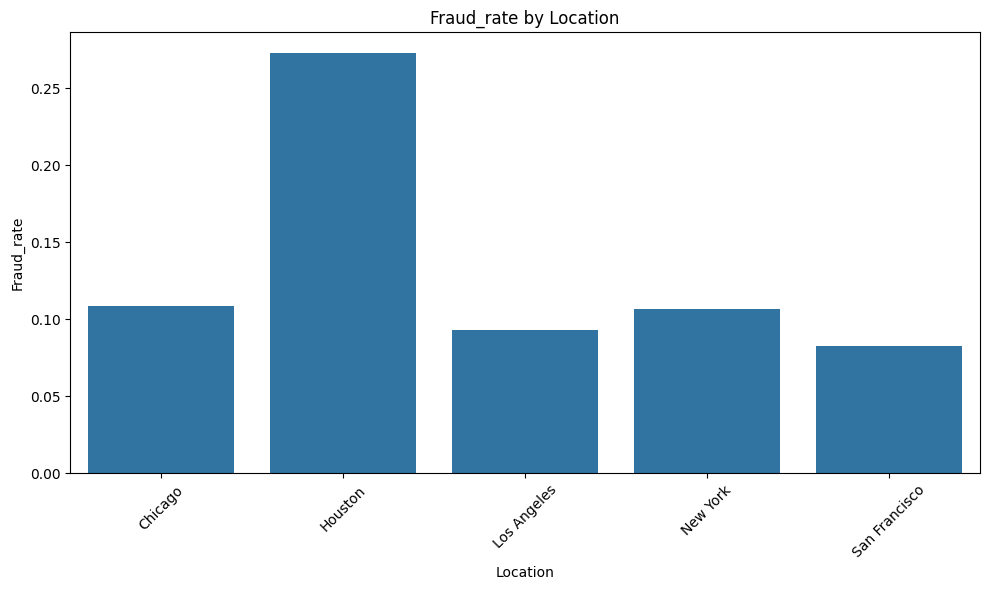

In [7]:
# To analyze relastionship between fraud rate and location
# The barchart below shows that the Fraud transaction rate of Huston is quite higher than that of other locations
Fraud_rate = df.groupby('Location')['Fraud'].value_counts(normalize=True).unstack().fillna(0)
Fraud_rate['Fraud_rate'] = Fraud_rate['Yes']
# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=Fraud_rate.index, y=Fraud_rate['Fraud_rate'])
plt.xlabel('Location')
plt.ylabel('Fraud_rate')
plt.title('Fraud_rate by Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Convert Fraud_label to binary
df['Fraud_label'] = np.where(df['Fraud'] == 'Yes', 1, 0)

In [10]:
# Check the percentage of 'Fraud' VS 'Non-fraud'
Transaction_type = df['Fraud_label'].value_counts(normalize=True)

# Print the class distribution
# the percentage check below shows that the data set is impalanced, since only 13.9% of transactions are Fraud
print(Transaction_type)

Fraud_label
0    0.8608
1    0.1392
Name: proportion, dtype: float64


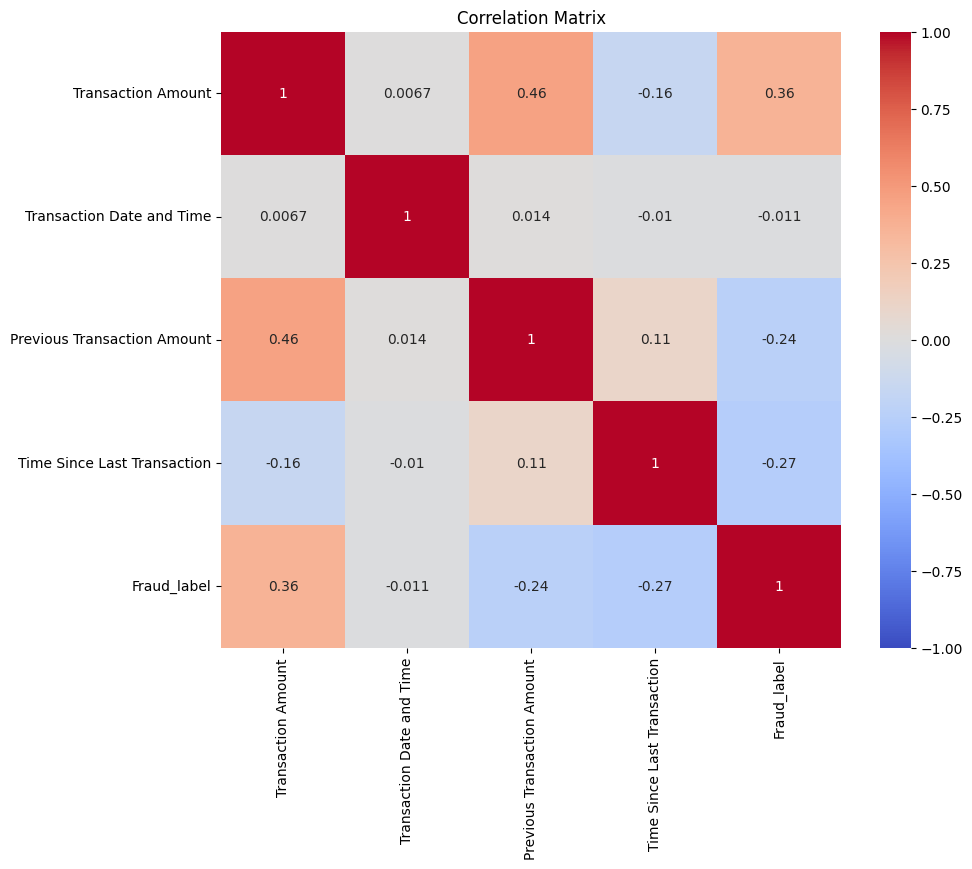

In [12]:
# build a correlation matrix to test correlation between numurous variables
correlation_matrix = df[['Transaction Amount','Transaction Date and Time','Previous Transaction Amount', 'Time Since Last Transaction','Fraud_label']].corr()

# Plot the correlation matrix
# The correlation matrix below shows that Fraud transaction has high correlation with Transaction Amount,Previous Transaction Amount and Time Since Last Transaction
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

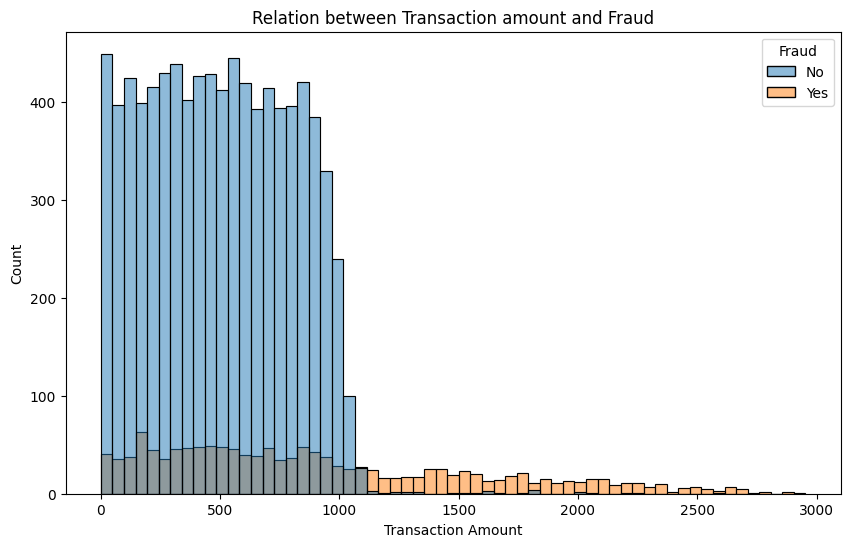

In [18]:
# To analyze relastionship between fraud rate and transaction amount
# The histplot shows that when transaction amount is bellow $1000, the fraud transaction percentage is low, 
# while the transaction amount become higher than $1000, the fraud rate increased exteremely
plt.figure(figsize=(10, 6))
sns.histplot(x=df['Transaction Amount'], hue=df['Fraud'])
plt.title('Relation between Transaction amount and Fraud')
plt.show()

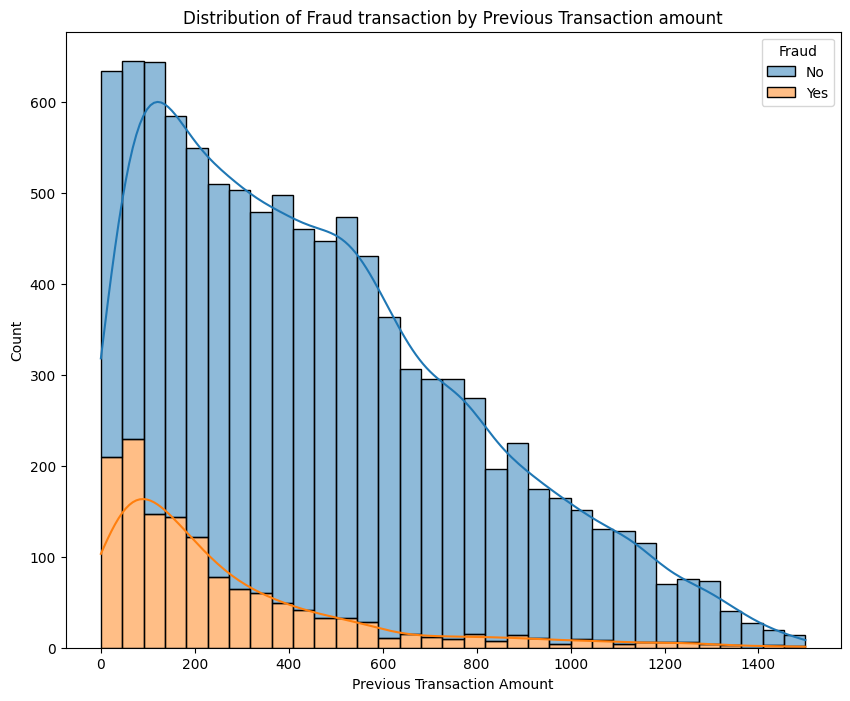

In [19]:
# To analyze relastionship between fraud rate and previous transaction amount
# The histplot shows that  
# there are more transactions which are detected as Fraud when Previous transaction amount is low,
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='Previous Transaction Amount', hue='Fraud', multiple='stack', kde=True)
plt.title('Distribution of Fraud transaction by Previous Transaction amount')
plt.show()

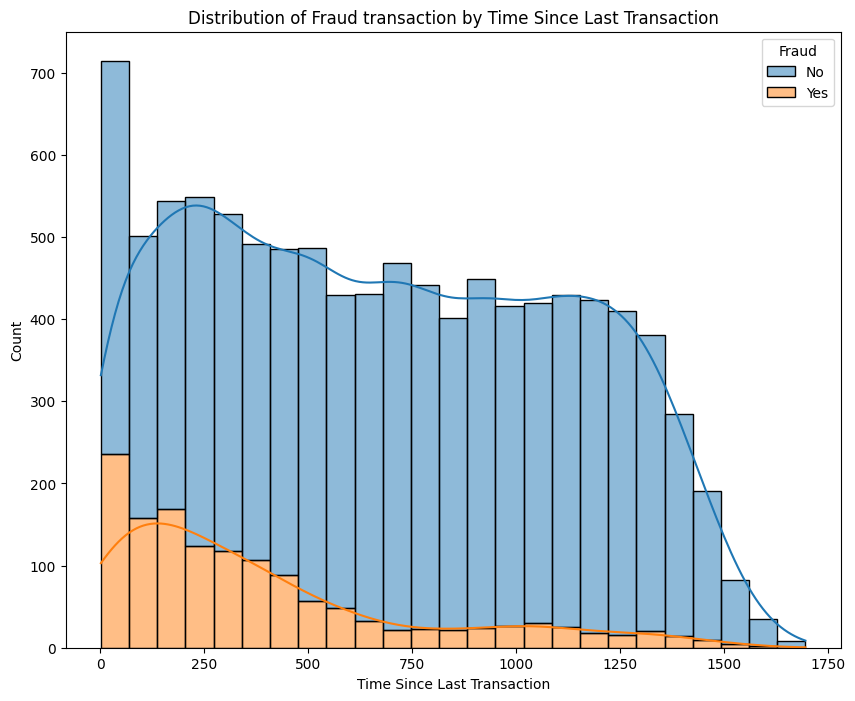

In [20]:
# To analyze relastionship between fraud rate and Time Since Last Transaction
# The histplot shows that  
# there are more transactions which are detected as Fraud when Time Since Last Transaction is close to current transaction
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='Time Since Last Transaction', hue='Fraud', multiple='stack', kde=True)
plt.title('Distribution of Fraud transaction by Time Since Last Transaction')
plt.show()

In [21]:
# Feture engineering


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [22]:
# define X and Y
y = df['Fraud_label']
X = df[['Location','Transaction Amount','Previous Transaction Amount','Time Since Last Transaction']]
# Identify numerical and categorical columns
numerical_cols = ['Transaction Amount','Previous Transaction Amount','Time Since Last Transaction']
categorical_cols = ['Location']
# Do OneHot Encoding and Scaling for X
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [32]:
# Model Building
# Test 4 models with cross validation to see which ones work best for this data
# Since the dataset is imbalanced, I choose to us F1 score instead of Accuracy as the indicator of Model selection
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()
dt = DecisionTreeClassifier()
# cross validation to determine in general which model works best for the given problem
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)
dt1_score = cross_val_score(dt1, X_train, y_train, scoring='f1', cv=5)
# High F1 score means better model
print(np.mean(logreg_scores))
print(np.mean(knn_scores))
print(np.mean(nb_scores))
print(np.mean(dt1_score))
# the F1 score shows that KNN model has the best performance
# GaussianNB is rejected since some of input variables are corelated, such as 'Transaction Amount' and 'Previous Transaction Amount'

0.6281109391846267
0.7271097883761197
0.5827604194234016
0.5898171799239647


In [33]:
# fit the models
log1 = logreg.fit(X_train,y_train)
knn1 = knn.fit(X_train,y_train)
nb1 = nb.fit(X_train,y_train)
dt1 = dt.fit(X_train,y_train)

pred_log1 = log1.predict(X_test)
pred_knn1 = knn1.predict(X_test)
pred_nb1 = nb1.predict(X_test)
pred_dt1 = dt1.predict(X_test)

In [27]:
# analyze the Performance of current KNN model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
print(classification_report(y_test, pred_knn1))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1736
           1       0.93      0.62      0.74       264

    accuracy                           0.94      2000
   macro avg       0.94      0.81      0.86      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
# model evaluation and model selection

In [28]:
# Try to optimize KNN Model

# Define the parameter grid for KNN
param_grid = {
'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 25, 35, 45],
'weights': ['uniform', 'distance'],
'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring= 'f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best F1 score: {best_f1_score:.4f}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best F1 score: 0.7295


In [29]:
# Apply the best combination of hyperparameter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Evaluating the model
# Make predictions on the test set
y_pred_knn = best_knn.predict(X_test)

# Evaluate the Logistic Regression model(Lower F1 score than Logistic Regression model, so not choose)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn= f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])
# Print the evaluation metrics
print(f'Accuracy: {accuracy_knn:.4f}')
print(f'Precision: {precision_knn:.4f}')
print(f'Recall: {recall_knn:.4f}')
print(f'F1 Score: {f1_knn:.4f}')
print(f'ROC AUC Score: {roc_auc_knn:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.9445
Precision: 0.9474
Recall: 0.6136
F1 Score: 0.7448
ROC AUC Score: 0.8419

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1736
           1       0.95      0.61      0.74       264

    accuracy                           0.94      2000
   macro avg       0.95      0.80      0.86      2000
weighted avg       0.94      0.94      0.94      2000



<Figure size 800x600 with 0 Axes>

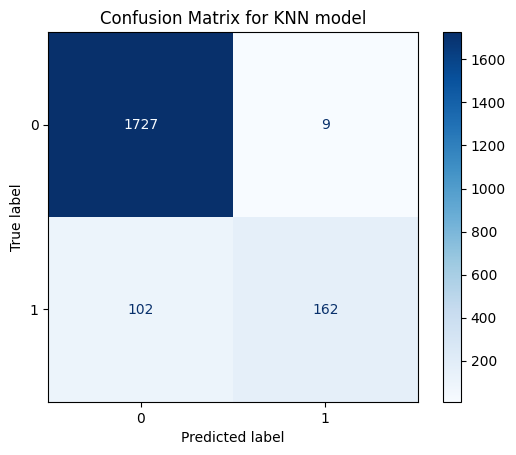

In [41]:
# Generate the confusion matrix for KNN model
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
cm_display_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=best_knn.classes_)
cm_display_logreg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN model')
plt.show()

<Figure size 1000x600 with 0 Axes>

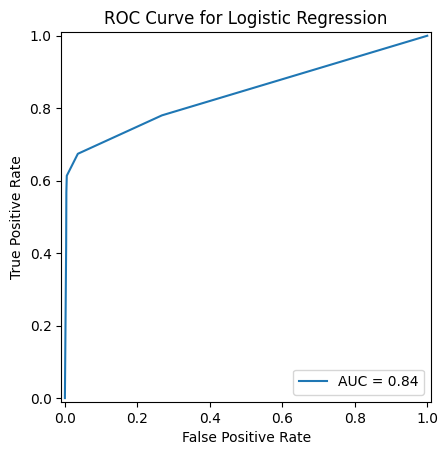

In [31]:
# Generate the ROC curve for KNN model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
fpr_logreg, tpr_logreg, thresholds_logred = roc_curve(y_test, best_knn.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
roc_display_logreg = RocCurveDisplay(fpr=fpr_logreg, tpr=tpr_logreg, roc_auc=roc_auc_knn)
roc_display_logreg.plot()
plt.title('ROC Curve for Logistic Regression')
plt.show()

In [34]:
# Try to Optimize Decition tree model
params = {'max_depth':[2,3,4,5,6,7,8]
          , 'min_samples_split': [8,10,15,20],
           'min_samples_leaf': [4, 8, 10, 20]}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(dt, params, cv=5,verbose=1, scoring= 'f1')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [4, 8, 10, 20],
                         'min_samples_split': [8, 10, 15, 20]},
             scoring='f1', verbose=1)

In [35]:
# pint best parameters
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best F1 score: {best_f1_score:.4f}')

Best parameters: {'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15}
Best F1 score: 0.7265


In [38]:
# fitting the model with the best Parameters
dt = DecisionTreeClassifier(max_depth = 7, min_samples_leaf=10, min_samples_split=15,random_state=123)
best_dt = dt.fit(X_train, y_train)

In [44]:
# Evaluating the model
# Make predictions on the test set
y_pred_dt = best_dt.predict(X_test)

# Evaluate the Logistic Regression model(Lower F1 score than Logistic Regression model, so not choose)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt= f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, best_dt.predict_proba(X_test)[:, 1])
# Print the evaluation metrics
print(f'Accuracy: {accuracy_dt:.4f}')
print(f'Precision: {precision_dt:.4f}')
print(f'Recall: {recall_dt:.4f}')
print(f'F1 Score: {f1_dt:.4f}')
print(f'ROC AUC Score: {roc_auc_dt:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_dt))
# Although the F1 score of Decision Tree Model is a little lower than that of KNN Model 
# It's Recall is higher than that of KNN model,
# Since the data set is imbalanced, and the Decision Tree Model is less affected by data imbalance
# So I choose Decision tree as my final model


Accuracy: 0.9415
Precision: 0.9106
Recall: 0.6174
F1 Score: 0.7359
ROC AUC Score: 0.8275

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1736
           1       0.91      0.62      0.74       264

    accuracy                           0.94      2000
   macro avg       0.93      0.80      0.85      2000
weighted avg       0.94      0.94      0.94      2000



<Figure size 800x600 with 0 Axes>

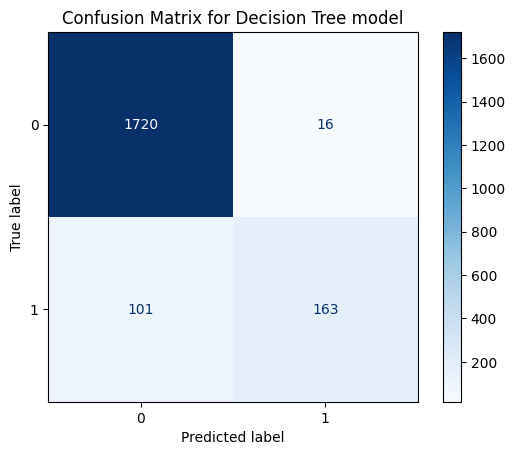

In [45]:
# Generate the confusion matrix for Decision Tree Model
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
cm_display_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=best_dt.classes_)
cm_display_logreg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree model')
plt.show()

<Figure size 1000x600 with 0 Axes>

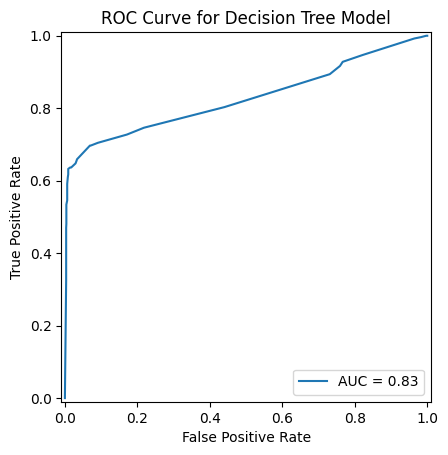

In [46]:
# Generate the ROC curve for Decision Tree Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, best_dt.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
roc_display_logreg = RocCurveDisplay(fpr=fpr_dt, tpr=tpr_dt, roc_auc=roc_auc_dt)
roc_display_logreg.plot()
plt.title('ROC Curve for Decision Tree Model')
plt.show()

In [47]:
# Try to Optimize logreg model
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Perform GridSearchCV
logreg = LogisticRegression(max_iter=1000)
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring= 'f1', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# Get the best parameters and the best F1 score
best_params_logreg = grid_search_logreg.best_params_
best_f1_score_logreg = grid_search_logreg.best_score_

print(f'Best parameters for Logistic Regression: {best_params_logreg}')
print(f'Best F1 score for Logistic Regression: {best_f1_score_logreg:.4f}')

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score for Logistic Regression: 0.6470


d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
175 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
       

In [48]:
# Apply the best combination of hyperparameter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
best_logreg = LogisticRegression(**best_params_logreg, max_iter=1000)
best_logreg.fit(X_train, y_train)

# Evaluating the model
# Make predictions on the test set
y_pred_logreg = best_logreg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f'Accuracy: {accuracy_logreg:.4f}')
print(f'Precision: {precision_logreg:.4f}')
print(f'Recall: {recall_logreg:.4f}')
print(f'F1 Score: {f1_logreg:.4f}')
print(f'ROC AUC Score: {roc_auc_logreg:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_logreg))

# After GridSearch, The Recall and F1 Score of Logestic Regression Model 
# is much lower than that of KNN and Decision Tree, so reject Logestic Regression Model

Accuracy: 0.9315
Precision: 0.9504
Recall: 0.5076
F1 Score: 0.6617
ROC AUC Score: 0.8420

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1736
           1       0.95      0.51      0.66       264

    accuracy                           0.93      2000
   macro avg       0.94      0.75      0.81      2000
weighted avg       0.93      0.93      0.92      2000



In [ ]:
# Explain my model to a business executive.


# Your data exploration findings
# 1. the Fraud transaction rate of Huston is quite higher than that of other locations
# 2. The higher the transaction amount is, the more likely a transaction can be a fraus transaction
# 3. The lesser the time since last transaction is , the more likely a transaction can be a fraus transaction
# 4. A transaction can be more likely a Fraud transaction if the Previous transaction amount is low.

# Initial hypothesis, and whether the hypothesis proved true.
# My initial Hypothesis is that the whether a transaction is a Fraud one can be predicted by following fetures
#'Location','Transaction Amount','Previous Transaction Amount' and 'Time Since Last Transaction'
# and my hypothesis is proved true by my models

# Approach for building and evaluating the model. 
# Input 'Location','Transaction Amount','Previous Transaction Amount' and 'Time Since Last Transaction' as X
# Input 'Fraud_label' as Y (Yes=1 and No=0)
# I try to fit the data with logestic regression, KNN classifier, Decision Tree and GaussianNB
# Sicce the data is imbalanced, I use F1 score and Recall as my indicator to select the best model

# The final model selected and how you know this is the best model for the problem.
# Finally, after Gridsearch, I choosed DecisionTree model as my final model,
# 1. It has a 73.59% F1 which shows that the model performs well, although a little lower than KNN's 74,4%
# 2. It has the highest Recall, and it is less effected by data imbalance than other models

# How the model should be used by the business, in business process.
# 1. The company can use this model to detect Fraud transactions by inputing following features:
#    'Location','Transaction Amount','Previous Transaction Amount' and 'Time Since Last Transaction'
# 2. The company should check a transaction carefully if it meets any of following conditions
#    - happened in Huston
#    - the amount is higher than $1000
#    - happened very close to the previous one
#    - The previous transaction amount is quite low